### Problem

The objective of this competition is to build a model, learned using historical data, that will determine an employee's access using role information and a resource code that will return whether or not access should be granted.

#### Label
* ACTION is 1 if the resource was approved, 0 if the resource was not

#### Features
* RESOURCE - An ID for each resource
* MGR_ID- The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time
* ROLE_ROLLUP_1 - Company role grouping category id 1 (e.g. US Engineering)
* ROLE_ROLLUP_2 - Company role grouping category id 2 (e.g. US Retail)
* ROLE_DEPTNAME - Company role department description (e.g. Retail)
* ROLE_TITLE - Company role business title description (e.g. Senior Engineering Retail Manager) - Same as Role Code
* ROLE_FAMILY_DESC - Company role family extended description (e.g. Retail Manager, Software Engineering)
* ROLE_FAMILY - Company role family description (e.g. Retail Manager)
* ROLE_CODE - Company role code; this code is unique to each role (e.g. Manager)

#### Scoring Method

![alt text](auc.png "AUC Illustration")

* True Positive Rate = TP / (TP + FN)
* False Positive Rate = FP / (FP + TN)


In [1]:
#inside a ipython/nb session
# Original Data in Pandas Dataframe : data
# Sparse Array for Training Data : X
# Sparse Array for Test Data : X_test
# Label for X only : y
# Offset : test_offset
# rf_data : Data Set for Random Forest Tree


#inside a ipython/nb session
# %store encoder
# Original Data in Pandas Dataframe
# %store data
# Sparse Array for Training Data
# %store X
# Sparse Array for Test Data
# %store X_test
# Label for X only
# %store y
# %store features
# %store header
# Offset 
# %store test_offset
# Data Set for Random Forest Tree
# %store rf_data
# Decision Tree Features
# %store dt_features

%store -r encoder
%store -r data
%store -r X
%store -r X_test
%store -r y
%store -r features
%store -r header
%store -r test_offset
%store -r rf_data
%store -r dt_features

In [20]:
import pandas as pd
import numpy as np
from itertools import combinations
import pickle
from pivottablejs import pivot_ui
from scipy.optimize import (minimize,basinhopping)
from scipy.stats import uniform as sp_rand

from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier,RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split

import seaborn as sb
import matplotlib.pyplot as plt  
%matplotlib inline

In [3]:
def save_results(predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("id,ACTION\n")
        for i, pred in enumerate(predictions):
            f.write("%d,%f\n" % (i + 1, pred))


In [27]:
df = pd.read_csv('train.csv')
dft = pd.read_csv('test.csv')

dfc = df.copy()
for col in df.columns:
  dfc[col] = df[col].astype('category')
dfc.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769,32769,32769,32769,32769,32769,32769,32769,32769,32769
unique,2,7518,4243,128,177,449,343,2358,67,343
top,1,4675,770,117961,118300,117878,118321,117906,290919,118322
freq,30872,839,152,21407,4424,1135,4649,6896,10980,4649


In [28]:
dftc = dft.copy()
for col in dft.columns:
  dftc[col] = dft[col].astype('category')
dftc.describe()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,58921,58921,58921,58921,58921,58921,58921,58921,58921,58921
unique,58921,4971,4689,126,177,466,351,2749,68,351
top,58921,4675,770,117961,118300,117878,118321,117906,290919,118322
freq,1,1989,276,37658,7731,2261,7433,11100,17881,7433


### Observations

* There are some role_code, role_family, role_family_desc, role_title, role_deptname, role_rollup_1 in the test set that is not in the training set
* The most frequent item in each category is the same for test and training set
* Role Code and Role Title has the same number of unique values

In [ ]:
pivot_ui(dfc)
# print(dfc[dfc['MGR_ID']==770].pivot_table(index=['ACTION'],aggfunc='count')['MGR_ID'])
# print(dfc[dfc['RESOURCE']==4675].pivot_table(index=['ACTION'],aggfunc='count')['RESOURCE'])
# print(dfc[dfc['ROLE_ROLLUP_1']==117961].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_ROLLUP_1'])
# print(dfc[dfc['ROLE_ROLLUP_2']==118300].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_ROLLUP_2'])
# print(dfc[dfc['ROLE_DEPTNAME']==117878].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_DEPTNAME'])
# print(dfc[dfc['ROLE_TITLE']==118321].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_TITLE'])
# print(dfc[dfc['ROLE_FAMILY_DESC']==117906].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_FAMILY_DESC'])
# print(dfc[dfc['ROLE_FAMILY']==290919].pivot_table(index=['ACTION'],aggfunc='count')['ROLE_FAMILY'])


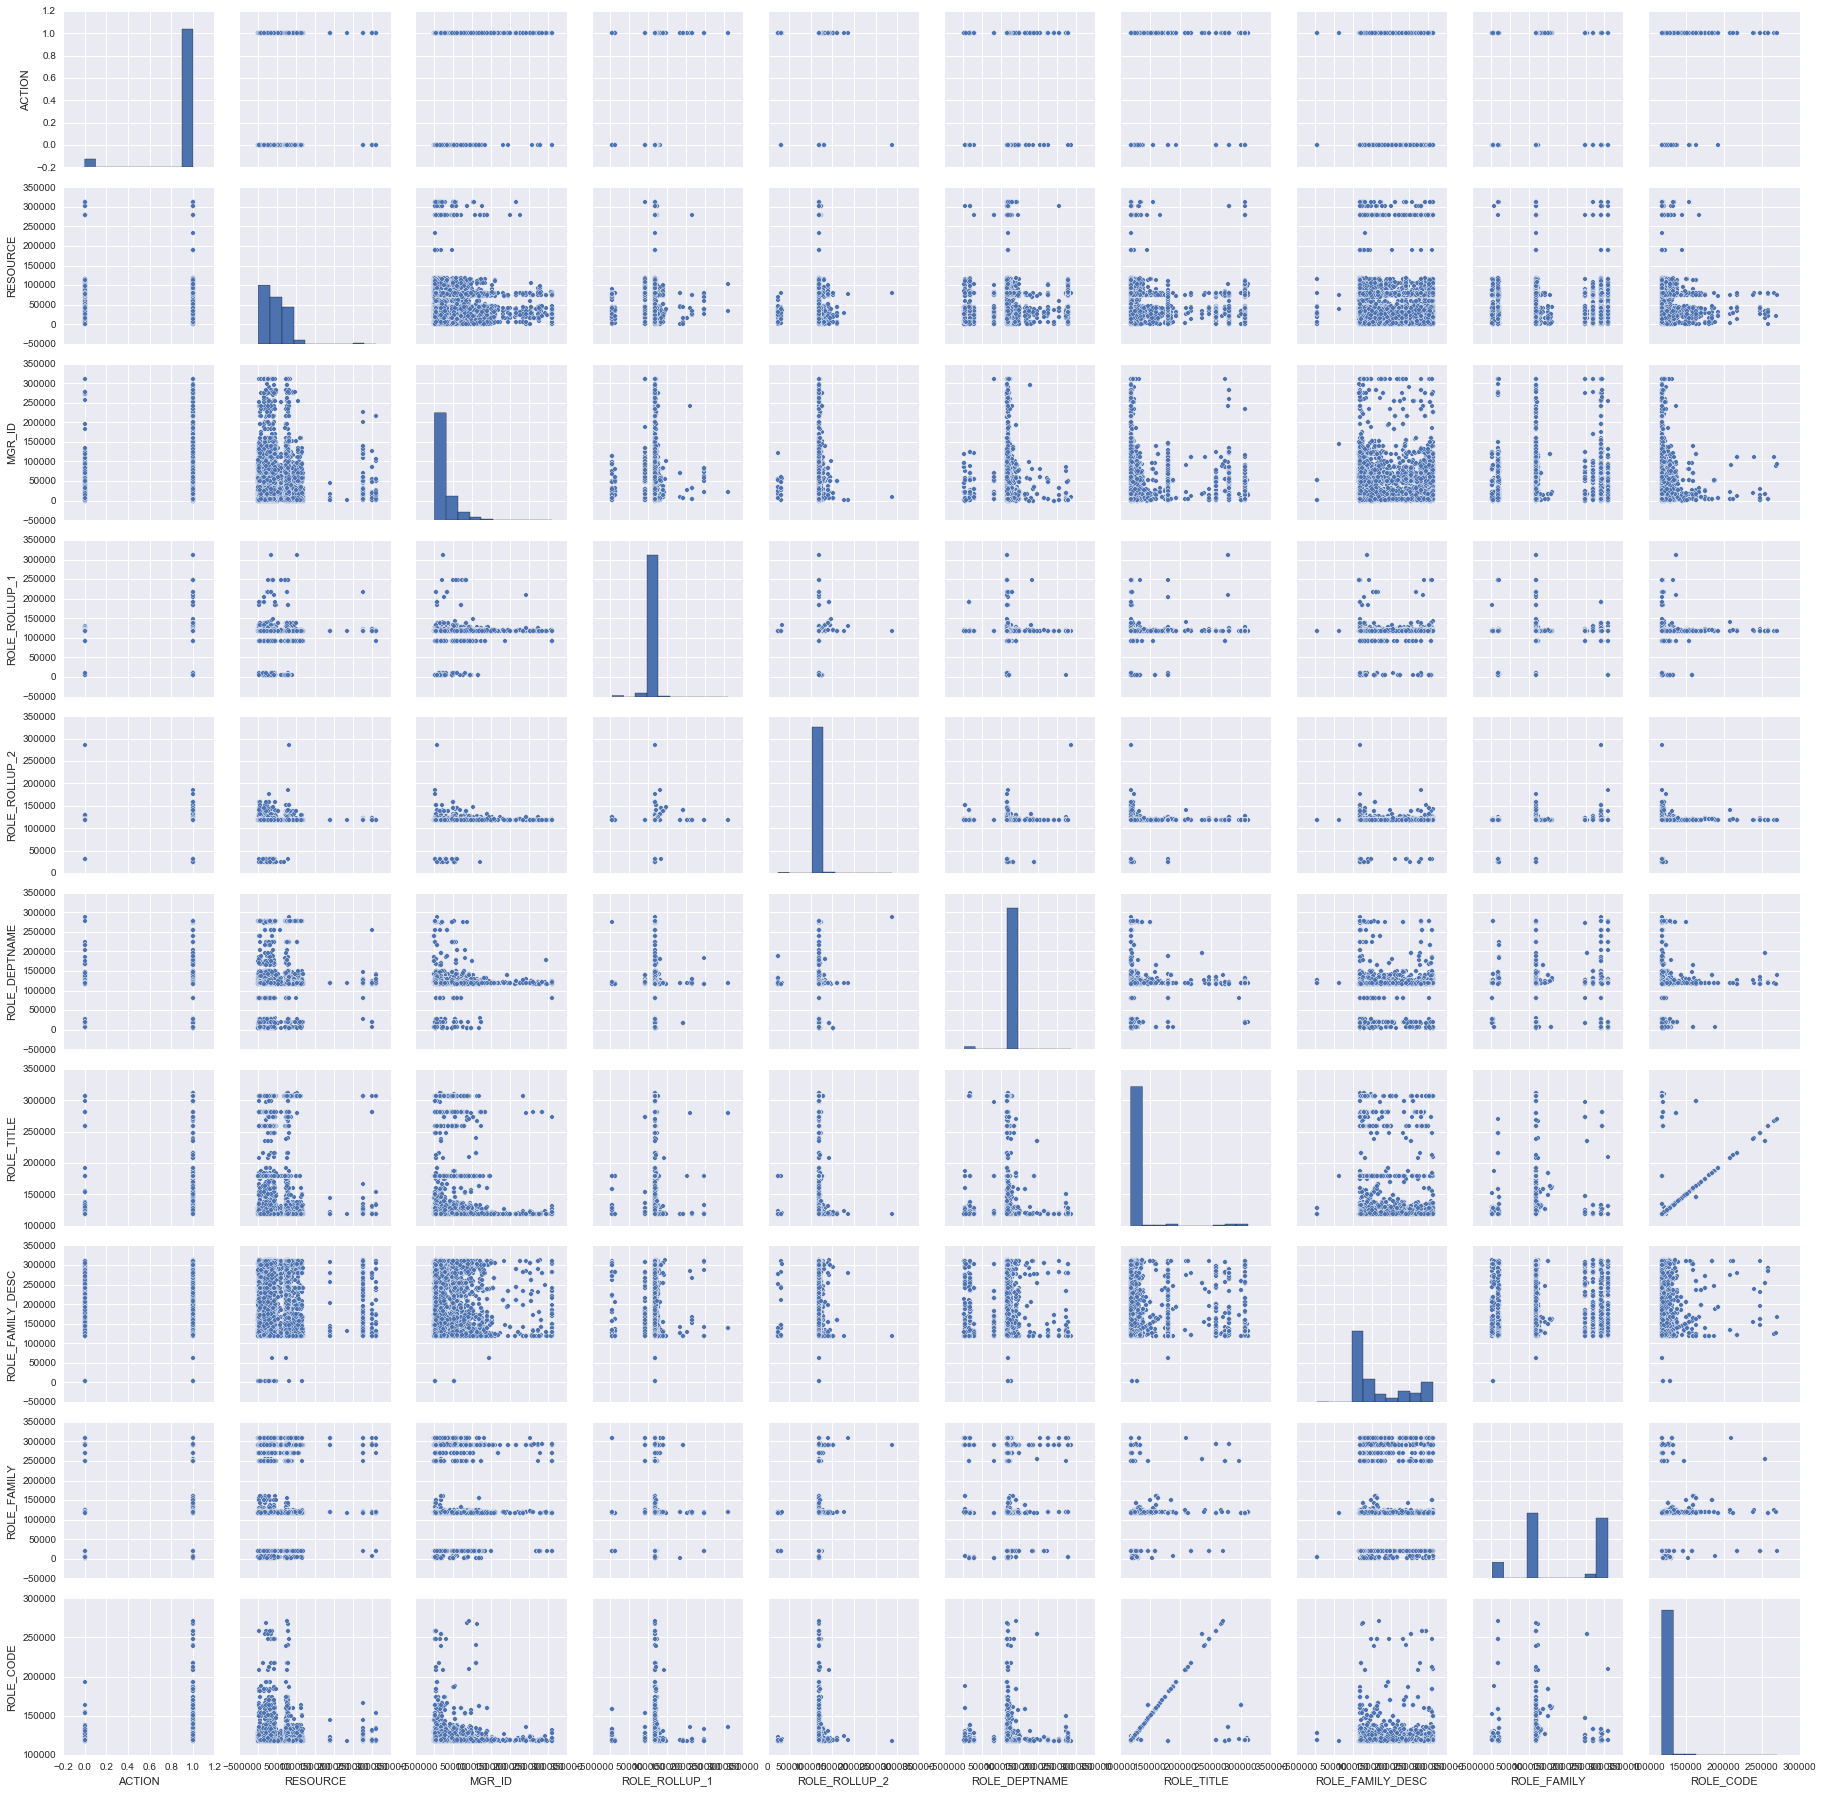

In [29]:
sb.pairplot(df)

In [ ]:
mult = {}
for c in df.columns:
    temp = df.pivot_table(index=c,aggfunc=lambda x:len(x.unique()),fill_value=0).apply(np.max)
    mult[c] = temp

multpd = pd.DataFrame(mult)
multpd[multpd.columns[1:]]

* Role Code to Role Title => 1:1
* Role Family to Role Code => 1 : M
* Role Family to Role Title => 1 : M
* Therefore Role Code = Role Title 

### Feature Generation

#### Cantor Pairing Function

![alt text](cantor.png "Cantor Formula")



In [ ]:
def cantor(pairs):
    result2 = 0.5 * (pairs[0] + pairs[1]) * (pairs[0] + pairs[1] +1) + pairs[1]
    if(len(pairs) == 2): 
        return result2
    if(len(pairs) == 3 ):
        result3 = 0.5 * (result2 + pairs[2]) * (result2 + pairs[2] +1) + pairs[2]
        return result3
    

In [ ]:
# Convert from dataframe to np.array
y = np.ravel(df.iloc[:,:1])
X = np.array(df.iloc[:,1:9])
X_test = np.array(dft.iloc[:,1:9])
header = list(df.columns[1:])

'''Since there are values in test set that is not available in training set, we combine together so that 
there will be consistent hasing '''
data = np.vstack((X,X_test))

# Get Combinations of 2 features 
for indices in combinations(range(8),2):
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b = indices
    header.append(header[a] +"&"+ header[b])

# Get Combinations of 3 features 
for indices in combinations(range(8),3):
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b,c = indices
    header.append(header[a] +"&"+ header[b]+ "&" + header[c])

print("Max Value Before Encoding ",np.ndarray.max(data))

le = preprocessing.LabelEncoder()
data_encode = []

for i in data.T:
    le.fit(i)
    data_encode.append(le.transform(i))

data = np.asarray(data_encode).T

print("Max Value After Encoding", np.ndarray.max(data))


In [ ]:
# Convert to One Hot Vector for scikit learn machine learning algorithms
test_offset = 32769

encoder = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in the training and the test set, so we fit the encoder on both
encoder.fit(data)
X = encoder.transform(data[:test_offset,:])
X_test = encoder.transform(data[test_offset:,:])
print(X.shape)
print(X_test.shape)

print("Total One Hot Features",encoder.active_features_)
print("Boundaries of each Feature",encoder.feature_indices_)
print("Number of unique values in each feature",encoder.n_values_)

### Feature Selection
http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

* Using Decision Tree
* Recursive Feature Elimination : Recursive feature elimination is based on the idea to repeatedly construct a model (for example an SVM or a regression model) and choose either the best or worst performing feature (for example based on coefficients), setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, it is a greedy optimization for finding the best performing subset of features.

In [ ]:
#Feature Selection 
dtc = DecisionTreeClassifier()
dtc.fit(X,y)
print(dtc.feature_importances_)
features = dtc.feature_importances_

start = 0
dt_prob_sum = []
for i in encoder.feature_indices_ : 
    if (i == 0) : continue 
    prob = features[start:i].sum()
    dt_prob_sum.append(prob)
    start = i + 1
    
dt_arr = np.array(dt_prob_sum)
# Get the 30 most significant features
dt_features = dt_arr.argsort()[-30:][::-1]
# Show the significance of feature in comparison to others
print(dt_arr[dt_features])
print("Sum of probaility for these features" ,np.sum((dt_arr[dt_arr.argsort()[-30:]])))
print([header[i] for i in dt_features])

In [17]:
dt_features.sort()
kaggle1 = [0, 8, 9, 10, 19, 34, 36, 37, 38, 41, 42, 43, 47, 53, 55, 60, 61, 63, 64, 67, 69, 71, 75, 81, 82, 85]
kaggle2 = [0, 1, 7, 8, 9, 10, 36, 37, 38, 41, 42, 43, 47, 51, 53, 56, 60, 61, 63, 64, 66, 67, 69, 71, 75, 79, 85, 91]
print("Kaggle 1", kaggle1)
print("Kaggle 2", kaggle2)
print("DT", dt_features[0:28])


Kaggle 1 [0, 8, 9, 10, 19, 34, 36, 37, 38, 41, 42, 43, 47, 53, 55, 60, 61, 63, 64, 67, 69, 71, 75, 81, 82, 85]
Kaggle 2 [0, 1, 7, 8, 9, 10, 36, 37, 38, 41, 42, 43, 47, 51, 53, 56, 60, 61, 63, 64, 66, 67, 69, 71, 75, 79, 85, 91]
DT [ 0  8  9 13 18 36 37 38 39 40 41 43 44 45 46 47 48 49 50 51 52 53 55 56 60
 64 66 69]


### Challenge - The huge number of features

In [18]:
#OneHotEncoder for the best features only
ufeatures = kaggle2
encode_bfeat = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in
# the training and the test set, so we fit the encoder on both
encode_bfeat.fit(data[:,ufeatures])
X = encode_bfeat.transform(data[:test_offset,ufeatures])
X_test = encode_bfeat.transform(data[test_offset:,ufeatures])
print(X.shape)
print(X_test.shape)

(32769, 688468)
(58921, 688468)


### Methods
* Naive Bayesian (Using Full set of Features)
* Logistic Regression (Using selected features) - Class Weight = 'Balanced' takes care of the highly imbalanced data
* Random Forest
* Majority Voting (Optimization)
* Ensemble Learning (Logistic Regression)


In [34]:
# Naive Bayesian

SEED = 42
mean_auc = 0.0

param_grid = {'alpha': sp_rand()}
model = MultinomialNB(alpha=0.177,fit_prior=True)

#X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X, y, test_size=.20, random_state=i*SEED)

rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring='roc_auc',cv=5)
rsearch.fit(X, y)

# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X, y)
preds = model.predict_proba(X_test)[:, 1]
save_results(preds, "submit_nb.csv")

0.861787573834
0.1813164139524276


#### Kaggle Dataset - 0.86617

In [ ]:
#Logistic Regression

SEED = 42
mean_auc = 0.0

n = 10  # repeat the CV procedure 10 times to get more precise results
model = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')
#model = BernoulliNB(alpha=0.005)
#model = ensemble.ExtraTreesClassifier(criterion='entropy',n_jobs=-1,verbose=1)
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X, y, test_size=.20, random_state=i*SEED)

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions
    model.fit(X_train, y_train) 
    preds = model.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (fold %d/%d): %f" % (i + 1, n, roc_auc))
    mean_auc += roc_auc
    # To print curve
#     plt.plot(fpr,tpr)
#     plt.show() 

print("Mean AUC: %f" % (mean_auc/n))

# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X, y)
preds = model.predict_proba(X_test)[:, 1]
save_results(preds, "submit_log.csv")

#### Cross Validation
* Kaggle Features - 0.895952
* Decision Tree Features - 0.886

#### Kaggle Score

* 0.89872

### Random Forest

https://blogs.technet.microsoft.com/machinelearning/2015/02/17/big-learning-made-easy-with-counts/
https://www.kaggle.com/c/caterpillar-tube-pricing/forums/t/15748/strategies-to-encode-categorical-variables-with-many-categories


How does “max_features” impact performance and speed?
Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered. However, this is not necessarily true as this decreases the diversity of individual tree which is the USP of random forest. But, for sure, you decrease the speed of algorithm by increasing the max_features. Hence, you need to strike the right balance and choose the optimal max_features.
 
n_estimators :
This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.
 
c. min_sample_leaf :
If you have built a decision tree before, you can appreciate the importance of minimum sample leaf size. Leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data. Generally I prefer a minimum leaf size of more than 50. However, you should try multiple leaf sizes to find the most optimum for your use case.

In [ ]:
#Count/Freq
for col in rf_data.columns:
    rf_data['cnt'+col] = 0
    groups = rf_data.groupby([col])
    # gid is the grouped col id, group is the actionable pandas data structure
    for gid, group in groups:
        #Count total number of rows with the same (MGR_ID,RESOURCE_ID etc) in the entire dataset
        count = group[col].count()
        #For all rows with the same "MGR_ID"/"RESOURCE_ID" , put the same count calculated in the previous step
        rf_data['cnt'+col].ix[group.index] = count 
    
# # Percent of dept that is this resource
for col in rf_data.columns[1:6]:
    rf_data['Duse'+col] = 0.0
    groups = rf_data.groupby([col])
    for name, group in groups:
        grps = group.groupby(['RESOURCE'])
        for rsrc, grp in grps:
            rf_data['Duse'+col].ix[grp.index] = float(len(grp.index)) / float(len(group.index) )

# #Number of resources that a manager manages
for col in rf_data.columns[0:1]:
    rf_data['Mdeps'+col] = 0
    groups = rf_data.groupby(['MGR_ID'])
    for name, group in groups:
        rf_data['Mdeps'+col].ix[group.index] = len(group[col].unique())

X = rf_data.values[:test_offset,6:18]
X_test = rf_data.values[test_offset:,6:18]

# X = rf_data.values[:test_offset,:]
# X_test = rf_data.values[test_offset:,:]

In [35]:
#Ensemble (Weighted Average) using Scipy to find optimal weights

Xf = rf_data.values[:test_offset,6:18]
Xf_test = rf_data.values[test_offset:,6:18]

SEED = 42

clf1 = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=None,max_features='sqrt',min_samples_split=9,random_state=SEED)
clf2 = ensemble.ExtraTreesClassifier(criterion='entropy',n_estimators=500,max_features='sqrt',min_samples_split=8,max_depth=None,random_state=SEED)
clf3 = GradientBoostingClassifier(max_depth=20,min_samples_split=9,random_state=SEED,learning_rate=0.2,n_estimators=50)
clf4 = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')

pave_coll = []
pave_y = []
rs = cross_validation.ShuffleSplit(len(y),n_iter=3,test_size=.2, random_state=SEED)
for train, test in rs:
    clf1.fit(Xf[train],y[train])
    clf2.fit(Xf[train],y[train])
    clf3.fit(Xf[train],y[train])
    clf4.fit(X[train],y[train])
    
    pclf1 = clf1.predict_proba(Xf[test])[:, 1]
    pclf2 = clf2.predict_proba(Xf[test])[:, 1]
    pclf3 = clf3.predict_proba(Xf[test])[:, 1]
    pclf4 = clf4.predict_proba(X[test])[:, 1]

    pave = np.vstack((pclf1,pclf2,pclf3,pclf4)).transpose()
    pave_coll.append(pave)
    pave_y.append(y[test]) 
    
pcoll = np.vstack(pave_coll)
py = np.hstack(pave_y)

# Optimize
# https://www.kaggle.com/hsperr/otto-group-product-classification-challenge/finding-ensamble-weights
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    prediction = np.asarray(np.mat(pcoll)*np.mat(weights.reshape(4,1)))
    # To Maximize , muliply by -1
    return (-1*metrics.roc_auc_score(py, prediction))
    
starting_values = np.array([0.25,0.25,0.25,0.25])
# Equality constraint means that the constraint function result is to be zero whereas inequality means that it is to be non-negative
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*4
res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons,options={'disp':True,'eps':0.001})
print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))
    
# === Predictions === #

clf1.fit(Xf, y)
clf2.fit(Xf, y)
clf3.fit(Xf, y)
clf4.fit(X, y)

predsRF = clf1.predict_proba(Xf_test)[:, 1]
predsET = clf2.predict_proba(Xf_test)[:, 1]
predsGB = clf3.predict_proba(Xf_test)[:, 1]
predsLR = clf4.predict_proba(X_test)[:, 1]

predsO = np.vstack((predsRF,predsET,predsGB,predsLR)).transpose()
predsOF = np.asarray(np.mat(predsO) * np.mat(res['x'].reshape(4,1)))
save_results(predsOF, "submit_optimize.csv") #0.91084



Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.896678396284
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
Ensamble Score: -0.8966783962844043
Best Weights: [ 0.23423432  0.06288324  0.10651253  0.59636991]


#### Score on Kaggle - 0.91084 (Kaggle 2) 
#### Score on Kaggle - 0.89645 (Decision Tree) 

### Results

* Use Inverse Logistic Function before putting it through the second logistic layer

In [36]:
#Ensemble (Logistic Regression)

Xf = rf_data.values[:test_offset,6:18]
Xf_test = rf_data.values[test_offset:,6:18]

SEED = 36

# clf1 = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=None,max_features='sqrt',min_samples_split=9,random_state=SEED)
# clf2 = ensemble.ExtraTreesClassifier(criterion='entropy',n_estimators=500,max_features='sqrt',min_samples_split=8,max_depth=None,random_state=SEED)
# clf3 = GradientBoostingClassifier(max_depth=20,min_samples_split=9,random_state=SEED,learning_rate=0.2,n_estimators=50)
# clf4 = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')

clf1 = RandomForestClassifier()
clf2 = ensemble.ExtraTreesClassifier()
clf3 = GradientBoostingClassifier()
clf4 = linear_model.LogisticRegression()

outer_cv = cross_validation.ShuffleSplit(len(y),n_iter=5,test_size=.2, random_state=SEED)
for traino, testo in outer_cv:
    Xfi = Xf[traino]
    Xi = X[traino]
    yi = y[traino]
    
    Xfti = Xf[testo]
    Xti = X[testo]
    yti = y[testo]
    
    inner_cv = cross_validation.ShuffleSplit(len(yi),n_iter=1,test_size=.2, random_state=SEED)
    for traini, testi in inner_cv:
        
        clf1.fit(Xfi[traini],yi[traini])
        clf2.fit(Xfi[traini],yi[traini])
        clf3.fit(Xfi[traini],yi[traini])
        clf4.fit(Xi[traini],yi[traini])
    
        pclf1 = clf1.predict_proba(Xfi[testi])[:, 1]
        pclf2 = clf2.predict_proba(Xfi[testi])[:, 1]
        pclf3 = clf3.predict_proba(Xfi[testi])[:, 1]
        pclf4 = clf4.predict_proba(Xi[testi])[:, 1]
    
        preds = np.hstack((pclf1,pclf2,pclf3,pclf4)).reshape(4,len(pclf1)).transpose()
        # Inverse logistic function
        preds[preds>0.9999999]=0.9999999
        preds[preds<0.0000001]=0.0000001
        preds = -np.log((1-preds)/preds)
        modelEn = linear_model.LogisticRegression()
        modelEn.fit(preds, yi[testi])
        
    
    
    predsRF = clf1.predict_proba(Xfti)[:,1]
    predsXT = clf2.predict_proba(Xfti)[:,1]
    predsGB = clf3.predict_proba(Xfti)[:,1]
    predsLR = clf4.predict_proba(Xti)[:,1]

#     predsRF[predsRF>0.9999999]=0.9999999
#     predsXT[predsXT>0.9999999]=0.9999999
#     predsGB[predsGB>0.9999999]=0.9999999
#     predsLR[predsLR>0.9999999]=0.9999999

#     predsRF[predsRF<0.0000001]=0.0000001
#     predsXT[predsXT<0.0000001]=0.0000001
#     predsGB[predsGB<0.0000001]=0.0000001
#     predsLR[predsLR>0.0000001]=0.0000001 
    
#     predsRF = -np.log((1-predsRF)/predsRF)
#     predsXT = -np.log((1-predsXT)/predsXT)
#     predsGB = -np.log((1-predsGB)/predsGB)
#     predsLR = -np.log((1-predsLR)/predsLR)
    
#     print("Model Coefficient :",modelEn.coef_)
#     coefRF = modelEn.coef_[0][0] 
#     coefXT = modelEn.coef_[0][1] 
#     coefGB = modelEn.coef_[0][2] 
#     coefLR = modelEn.coef_[0][3] 
#     x = coefRF * predsRF + coefXT * predsXT + coefGB * predsGB + coefLR * predsLR
#     preds_x = 1 / (1 + np.exp(-x))
    predsX = np.hstack((predsRF,predsXT,predsGB,predsLR)).reshape(4,len(predsRF)).transpose()
    # Inverse logistic function
    predsX[predsX>0.9999999]=0.9999999
    predsX[predsX<0.0000001]=0.0000001
    predsX = -np.log((1-predsX)/predsX)
    cvo = modelEn.predict_proba(predsX)[:,1]
       

    print(metrics.roc_auc_score(yti, cvo))
    


0.887694461423
0.888586370148
0.895047679543
0.886812110303
0.897526362975


In [15]:
# === Predictions === #


# coefRF = 0.02630695
# coefXT = 0.03123936
# coefGB = 0.21050898
# coefLR = 0.54943844

clf1.fit(Xf, y)
clf2.fit(Xf, y)
clf3.fit(Xf, y)
clf4.fit(X, y)

predsRF = clf1.predict_proba(Xf_test)[:, 1]
predsXT = clf2.predict_proba(Xf_test)[:, 1]
predsGB = clf3.predict_proba(Xf_test)[:, 1]
predsLR = clf4.predict_proba(X_test)[:, 1]

# predsRF[predsRF>0.9999999]=0.9999999
# predsXT[predsXT>0.9999999]=0.9999999
# predsGB[predsGB>0.9999999]=0.9999999
# predsLR[predsLR>0.9999999]=0.9999999

# predsRF[predsRF<0.0000001]=0.0000001
# predsXT[predsXT<0.0000001]=0.0000001
# predsGB[predsGB<0.0000001]=0.0000001
# predsLR[predsLR>0.0000001]=0.0000001

# predsRF = -np.log((1-predsRF)/predsRF)
# predsXT = -np.log((1-predsXT)/predsXT)
# predsGB = -np.log((1-predsGB)/predsGB)
# predsLR = -np.log((1-predsLR)/predsLR)

# xf = coefRF * predsRF + coefXT * predsXT + coefGB * predsGB + coefLR * predsLR
# predsE = 1 / (1 + np.exp(-xf))

predsE = np.hstack((predsRF,predsXT,predsGB,predsLR)).reshape(4,len(predsRF)).transpose()
# Inverse logistic function
predsE[predsE>0.9999999]=0.9999999
predsE[predsE<0.0000001]=0.0000001
predsE = -np.log((1-predsE)/predsE)
predsE = modelEn.predict_proba(predsE)[:,1]
   
save_results(predsE, "submit_ensemble.csv") 

#### Kaggle Score - 0.91096
#### Decision Tree - 0.90485